## Setup

In [1]:
import torch
import numpy as np
import os, sys, time 
import pandas as pd
import zipfile, tarfile, requests  # TODO: Ensure package requests is installed

import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from patsy import dmatrices
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize

# packages required for k-means and PCA
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [3]:
# packages required for proecessing zip files
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

# packages for plots and graphs
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import requests, zipfile

In [4]:
!pip install kaggle

In [5]:
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download ellipticco/elliptic-data-set

elliptic-data-set.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
def getData():
    with ZipFile("elliptic-data-set.zip") as zfile:
        df_node_transactions = pd.read_csv(zfile.open('elliptic_bitcoin_dataset/elliptic_txs_classes.csv'))
        df_edge_payments = pd.read_csv(zfile.open('elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv'))
        df_features = pd.read_csv(zfile.open('elliptic_bitcoin_dataset/elliptic_txs_features.csv'))
    return df_node_transactions,df_edge_payments,df_features

The dataset consists of 203,769 transactions, of which 21% are
labeled as licit, and 2% as illicit, based on the category of the bitcoin
address that created the transaction. The remaining transactions
are unlabeled. Illicit categories include scams, malware, terrorist organizations, and Ponzi schemes. Licit categories include exchanges,
wallet providers, miners, and licit services. Each transaction has 166
features, 94 of which represent information about the transaction
itself. The remaining features were constructed 
using information one-hop backward/forward from the transaction,
such as the minimum, maximum, and standard deviation of each
transaction feature. All features, except for the time-step, are fully
anonymized and standardized with zero mean and unit variance.

In [7]:
df_node_transactions,df_edge_payments,df_features = getData()

Nodes and Edges. There are 203,769 node transactions and
234,355 directed edge payments flows. 

In [8]:
df_node_transactions.head()

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [9]:
df_edge_payments.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


Features. Each node has associated 166 features. The first 94
features represent local information about the transaction – including the time step, number of inputs/outputs, transaction fee, output
volume and aggregated figures such as average BTC received (spent)
by the inputs/outputs and average number of incoming (outgoing)
transactions associated with the inputs/outputs. The remaining 72
features, called aggregated features, are obtained by aggregating
transaction information one-hop backward/forward from the center node - giving the maximum, minimum, standard deviation and
correlation coefficients of the neighbour transactions for the same
information data (number of inputs/outputs, transaction fee, etc.).

In [10]:
df_features.head()

,230425980,1,-0.1714692896288031,-0.18466755143291433,-1.2013688016765636,-0.12196959975910057,-0.04387454791734898,-0.11300200928476244,-0.06158379407303222,-0.16209679981659642,-0.16793302645225652,-0.04970696439403985,-0.16440217329951,-0.028741285856664783,-0.035390552600813516,-0.042955299258028254,-0.013281614870058885,-0.057194633660791555,-0.16960915015560768,-0.17115370708833458,-0.1744725474413385,-1.3736571773938961,-1.3714598276027399,-0.13973120192279553,-0.1489118870463073,-0.08014726965335221,-0.15566142432803598,-0.010763009512837094,-0.012107451777478418,-0.13973300164963834,-0.14890718609704007,-0.08014673584659182,-0.1556613943053229,-0.0106685610738475,-0.012005182118417812,-0.02466883065625352,-0.031272390486630317,-0.0230451563960962,-0.026214655177430907,0.001427813709709475,...,-0.09771859912616487,-0.12746225048300552,0.0031432964315106413,0.0024263098865888125,-0.1209504155034722,-0.19914489882884956,-0.18799267262971858,-0.21294750674116758,1.0642045463479908,1.0637874876466933,-1.3737824923785267,-1.3547347717590499,-0.29797501416794375,-1.4036981050621322,1.342003002186918,1.3407327277377104,-0.17160149344087147,-0.4581618412195745,-0.4235879631572251,-0.44088282778065335,-1.0159633735173061,-1.0162304272806977,-0.968902874660573,-0.37571453141267186,0.759748200156594,-0.7683292540299814,1.4881129012284324,1.487932476808418,-0.21681436061843226,-0.6056310578523486,-0.5621534802884299,-0.6009988905192808,1.4613303209554889,1.4613689382001922,0.01827940003744589,-0.0874901561101501,-0.13115530389558736,-0.09752359377152515,-0.12061340670311574,-0.11979245961251665
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,...,0.019771,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314,1,1.011523,-0.081127,-1.2013

In [11]:
colNames1 = {'0': 'txId', '1': "Time step"}
colNames2 = {str(i+2): "Local_feature_" + str(i+1) for i in range(93)}
colNames3 = {str(j+95): "Aggregate_feature_" + str(j+1) for j in range(72)}
#combine dictionaries
colNames = dict(**colNames1, **colNames2, **colNames3 )

In [12]:
df_features.columns = colNames.values()
df_features.head()

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,Local_feature_11,Local_feature_12,Local_feature_13,Local_feature_14,Local_feature_15,Local_feature_16,Local_feature_17,Local_feature_18,Local_feature_19,Local_feature_20,Local_feature_21,Local_feature_22,Local_feature_23,Local_feature_24,Local_feature_25,Local_feature_26,Local_feature_27,Local_feature_28,Local_feature_29,Local_feature_30,Local_feature_31,Local_feature_32,Local_feature_33,Local_feature_34,Local_feature_35,Local_feature_36,Local_feature_37,Local_feature_38,...,Aggregate_feature_33,Aggregate_feature_34,Aggregate_feature_35,Aggregate_feature_36,Aggregate_feature_37,Aggregate_feature_38,Aggregate_feature_39,Aggregate_feature_40,Aggregate_feature_41,Aggregate_feature_42,Aggregate_feature_43,Aggregate_feature_44,Aggregate_feature_45,Aggregate_feature_46,Aggregate_feature_47,Aggregate_feature_48,Aggregate_feature_49,Aggregate_feature_50,Aggregate_feature_51,Aggregate_feature_52,Aggregate_feature_53,Aggregate_feature_54,Aggregate_feature_55,Aggregate_feature_56,Aggregate_feature_57,Aggregate_feature_58,Aggregate_feature_59,Aggregate_feature_60,Aggregate_feature_61,Aggregate_feature_62,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.097719,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,...,0.019771,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057

In [13]:
print('Shape of classes', df_node_transactions.shape)
print('Shape of edges', df_edge_payments.shape)
print('Shape of features', df_features.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203768, 167)


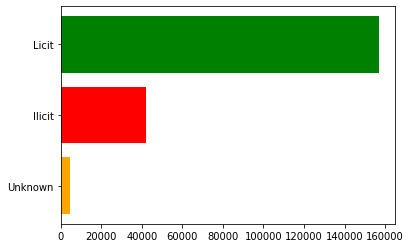

In [14]:
df_node_transactions.loc[df_node_transactions['class'] == 'unknown', 'class'] = '3'
group_class = df_node_transactions.groupby('class').count()
plt.barh(['Unknown', 'Ilicit', 'Licit'], group_class['txId'].values, \
         color=['orange', 'r', 'g'] );

### Number of transactions per Time step

Text(0.5, 1.0, 'Number of transactions by Time step')

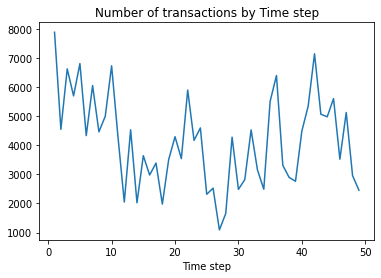

In [15]:
group_feature = df_features.groupby('Time step').count()
group_feature['txId'].plot()
plt.title('Number of transactions by Time step')

In [16]:
print(len(df_node_transactions.txId.unique()))
len(df_features.txId.unique())

203769


203768

In [17]:
# Merge Class and features
df_nodetrans_feature = pd.merge(df_features,df_node_transactions, on='txId',how='left' )

df_nodetrans_feature.head()

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,Local_feature_11,Local_feature_12,Local_feature_13,Local_feature_14,Local_feature_15,Local_feature_16,Local_feature_17,Local_feature_18,Local_feature_19,Local_feature_20,Local_feature_21,Local_feature_22,Local_feature_23,Local_feature_24,Local_feature_25,Local_feature_26,Local_feature_27,Local_feature_28,Local_feature_29,Local_feature_30,Local_feature_31,Local_feature_32,Local_feature_33,Local_feature_34,Local_feature_35,Local_feature_36,Local_feature_37,Local_feature_38,...,Aggregate_feature_34,Aggregate_feature_35,Aggregate_feature_36,Aggregate_feature_37,Aggregate_feature_38,Aggregate_feature_39,Aggregate_feature_40,Aggregate_feature_41,Aggregate_feature_42,Aggregate_feature_43,Aggregate_feature_44,Aggregate_feature_45,Aggregate_feature_46,Aggregate_feature_47,Aggregate_feature_48,Aggregate_feature_49,Aggregate_feature_50,Aggregate_feature_51,Aggregate_feature_52,Aggregate_feature_53,Aggregate_feature_54,Aggregate_feature_55,Aggregate_feature_56,Aggregate_feature_57,Aggregate_feature_58,Aggregate_feature_59,Aggregate_feature_60,Aggregate_feature_61,Aggregate_feature_62,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,class
0,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,-0.167948,-0.049707,-0.164417,-0.028741,-0.035391,-0.042955,-0.013282,-0.055327,-0.169757,-0.171477,-0.174490,0.887058,0.884557,-0.139731,-0.148912,-0.080147,-0.155661,-0.010763,-0.012107,-0.139733,-0.148907,-0.080147,-0.155661,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.127462,0.003143,0.002426,-0.121330,-0.110933,-0.075909,-0.111641,-1.159649,-1.160129,-1.373723,-1.353918,-0.295982,-1.403215,-0.975738,-0.975237,-0.168742,-0.263290,-0.186389,-0.250875,-1.015963,-1.016230,-0.968903,0.146997,1.366287,-0.464773,-1.116918,-1.116948,-0.216814,0.634272,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,3
1,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,-0.168576,-0.049707,-0.165054,-0.028741,-0.035391,-0.042955,-0.013282,-0.055298,-0.170400,-0.172217,-0.175227,0.887058,0.884557,-0.139729,-0.148911,-0.080147,-0.155660,-0.010763,-0.012107,-0.139731,-0.148906,-0.080147,-0.155660,-0.010669,-0.012005,-0.024669,-0.031272,-0.023045,-0.026215,0.001428,...,-0.129496,0.003143,0.002426,-0.122974,-0.041556,0.012549,-0.032244,-1.159649,-1.160129,-1.373902,-1.356210,-0.301548,-1.404577,-0.975738,-0.975237,-0.168742,-0.192468,-0.099790,-0.182133,-1.015963,-1.016230,-0.968903,-1.421138,-0.453330,-1.375441,-1.116918,-1.116948,-0.216814,0.407161,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,3
2,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,-0.115831,0.043598,-0.163905,1.059993,2.397457,-0.063200,-0.013282,4.800240,0.174329,-0.172908,0.619399,-0.243300,-0.243452,-0.139732,-0.146895,-0.079667,-0.155554,0.773847,0.378516,-0.139734,-0.146891,-0.079667,-0.155553,0.773932,0.378593,-0.024669,-0.031271,-0.023044,-0.026215,0.101008,...,-0.119195,0.147881,0.956170,0.759756,-0.041556,-0.188716,0.149949,-0.047722,-0.048171,-1.373723,-1.356131,-0.301754,-1.404445,0.183133,0.182748,-0.163577,-0.456561,-0.424672,-0.436915,0.143001,0.142525,-0.425896,-1.421138,-1.059868,-1.071885,0.185597,0.185492,-0.216814,-0.617907,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,2
3,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,0.041399,0.935886,-0.098695,1.203038,0.988902,0.341693,-0.013282,-0.057392,0.058329,-0.032930,-0.042709,0.065

In [18]:
nodetrans_feature = df_nodetrans_feature.groupby(['Time step', 'class']).count()
nodetrans_feature = nodetrans_feature['txId'].reset_index().\
rename(columns={'txId': 'count'})#unstack()
nodetrans_feature.head()

,Time step,class,count
0,1,1,17
1,1,2,2130
2,1,3,5732
3,2,1,18
4,2,2,1099


Text(0.5, 0, 'Time step')

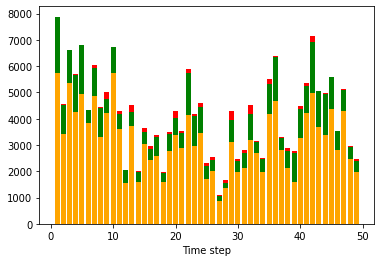

In [19]:
class1 = nodetrans_feature[nodetrans_feature['class'] == '1']
class2 = nodetrans_feature[nodetrans_feature['class'] == '2']
class3 = nodetrans_feature[nodetrans_feature['class'] == '3']

p1 = plt.bar(class3['Time step'], class3['count'], color = 'orange')

p2 = plt.bar(class2['Time step'], class2['count'], color='g',
             bottom=class3['count'])

p3 = plt.bar(class1['Time step'], class1['count'], color='r',
             bottom=np.array(class3['count'])+np.array(class2['count']))

plt.xlabel('Time step')

##  Train Test split


The train set includes all labeled samples up to the 34th time-step (29894 transactions), and the test set includes all labeled samples from the 35th time-step, inclusive, onward (16670
transactions)

In [20]:
data = df_nodetrans_feature.loc[df_nodetrans_feature['class'].isin(('1','2'))]
X = data.drop(['class','txId'], axis=1)
y = data['class']
y = np.where(y=='2',0,1)
print('X shape: {}'.format(X.shape))
print('y count:\n{}'.format(pd.value_counts(y)))

X shape: (46564, 166)
y count:
0    42019
1     4545
dtype: int64


### Label Propagation

In [21]:
# X train mixed
labeled = df_nodetrans_feature.loc[df_nodetrans_feature['class'].isin(('1','2'))]
X = labeled.drop(['class', 'txId'], axis=1)

y = labeled['class']
y = np.where(y=='2', 0, y) # licit
y = np.where(y=='1', 1, y) # illicit

                                   
X_train = X[X['Time step'] <= 34]
X_test = X[X['Time step'] >= 35]
                                   
y_train = y[X['Time step'] <= 34]
y_test = y[X['Time step'] >= 35]


# save timestep
y_test_timestep = X_test.copy()['Time step']
X_test.drop(['Time step'], axis=1, inplace=True)
X_train.drop(['Time step'], axis=1, inplace=True)
X_test = X_test.loc[y_test != -1] # drop unknown
y_test = np.delete(y_test, np.where(y_test == -1)) # drop unknown


print('y training data count:')
print(pd.value_counts(y_train))
print('y test data count:')
print(pd.value_counts(y_test))

y training data count:
0    26432
1     3462
dtype: int64
y test data count:
0    15587
1     1083
dtype: int64


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [22]:
unlabeled = df_nodetrans_feature[df_nodetrans_feature['class']=='3']
unlabeled = unlabeled[unlabeled['Time step'] <= 34]
drop_indices = np.random.choice(unlabeled.index, int(0.95*106370), replace=False)
subset_unlab = unlabeled.drop(drop_indices)

X_train_unlab = subset_unlab.drop(['class', 'txId', 'Time step'], axis=1)
y_train_unlab = [-1 for _ in range(len(X_train_unlab))]

X_train_mixed = pd.concat([X_train, X_train_unlab])
y_train_mixed = np.concatenate((y_train, y_train_unlab))

print(X_train_mixed.shape)
print(np.)

(35213, 165)


In [ ]:
from sklearn.semi_supervised import LabelPropagation
model = LabelPropagation()
model.fit(X_train_mixed, y_train_mixed.astype('int'))
yhat = model.predict(X_test)
score = f1_score(y_test.astype('int'), yhat)
score

0.0